## Importing libraries

In [199]:
pip install -U xgboost

Note: you may need to restart the kernel to use updated packages.


In [231]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

## Data Loading

In [202]:
df = pd.read_csv("auction_model_ready.csv")
df.head()

,artist,country,yearofbirth,year,price,material,height,width,brightness,ratiouniquecolors,...,lowbrightnessperc,cornerper,edgeper,facecount,area,sold_year,year_missing,sold_year_missing,log_price,artist_score
0,Mario A,194,1959.0,2004.0,5315.0,4009,29.53,39.37,-0.954247,0.124644,...,0.504312,-0.686356,-1.012415,2.481235,0.063918,-1.0,0,1,8.578476,2
1,Mario A,194,1959.0,2004.0,7383.0,4007,29.53,39.37,-1.443571,-0.205246,...,2.288847,-0.105690,-0.498196,-0.277766,0.063918,-1.0,0,1,8.907071,2
2,A E Cremer,135,1950.0,-1.0,2090.0,738,19.88,20.00,1.277067,-0.974988,...,0.218099,-0.676258,-0.991909,-0.277766,-0.119986,-1.0,1,1,7.645398,1
3,A G Schultz & Co.,84,1890.0,-1.0,615.0,7527,6.50,5.75,-1.443571,-0.260227,...,1.518935,0.934459,0.424559,-0.277766,-0.206584,-1.0,1,1,6.423247,2
4,A G Schultz & Co.,84,1890.0,1908.0,8125.0,7415,19.88,20.00,1.355359,-1.139933,...,-0.589736,-0.242021,0.396166,-0.277766,-0.119986,-1.0,0,1,9.002824,2


In [203]:
df = df.drop(columns=['artist'])

In [204]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40804 entries, 0 to 40803
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             40804 non-null  int64  
 1   yearofbirth         40804 non-null  float64
 2   year                40804 non-null  float64
 3   price               40804 non-null  float64
 4   material            40804 non-null  int64  
 5   height              40804 non-null  float64
 6   width               40804 non-null  float64
 7   brightness          40804 non-null  float64
 8   ratiouniquecolors   40804 non-null  float64
 9   thresholdblackperc  40804 non-null  float64
 10  highbrightnessperc  40804 non-null  float64
 11  lowbrightnessperc   40804 non-null  float64
 12  cornerper           40804 non-null  float64
 13  edgeper             40804 non-null  float64
 14  facecount           40804 non-null  float64
 15  area                40804 non-null  float64
 16  sold

## Train-Test Splits

In [206]:
# Splitting the dataset into 80% training and 2-% testing
X = df.drop(columns=['price','log_price'])
y = df['log_price']

# 1. Split train_full + test (80/20)
train_full_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# 2. Split train_full into validation and train (each 20%)
train_df, val_df = train_test_split(train_full_df, test_size=0.25, random_state=42)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Train: 24482, Val: 8161, Test: 8161


## Models

## Linear Regression

In [209]:
X_train = train_df.drop(columns=['price', 'log_price'])
y_train = train_df['log_price']
X_val = val_df.drop(columns=['price', 'log_price'])
y_val = val_df['log_price']

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)
print(f"Linear Regression → RMSE: {rmse:.3f}, R²: {r2:.3f}")

Linear Regression → RMSE: 1.573, R²: 0.423


## Random Forest Regressor

In [211]:
rf = RandomForestRegressor(
    n_estimators=150,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)
print(f"Random Forest → RMSE: {rmse:.3f}, R²: {r2:.3f}")


Random Forest → RMSE: 1.226, R²: 0.649


## XGBoost

In [213]:
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)
print(f"XGBoost → RMSE: {rmse:.3f}, R²: {r2:.3f}")


XGBoost → RMSE: 1.113, R²: 0.711


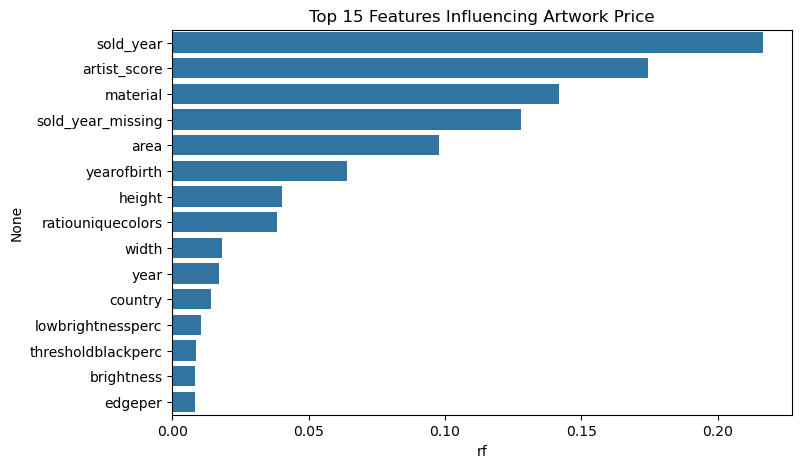

In [214]:
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
top_features = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(8,5))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Top 15 Features Influencing Artwork Price")
plt.xlabel('rf')
plt.show()


## Test Set Evaluation

In [216]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Separate features and target
X_test = test_df.drop(columns=['price', 'log_price'])
y_test = test_df['log_price']

models = {
    "Linear Regression": lr,
    "Random Forest": rf,
    "XGBoost": xgb
}

results = []

# Loop through and evaluate each model
for name, model in models.items():
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append({"Model": name, "RMSE": rmse, "R2": r2})

# Create a summary DataFrame
results_df = pd.DataFrame(results).sort_values(by="RMSE")
print(results_df)

               Model      RMSE        R2
2            XGBoost  1.091556  0.732267
1      Random Forest  1.228802  0.660708
0  Linear Regression  1.588546  0.432965


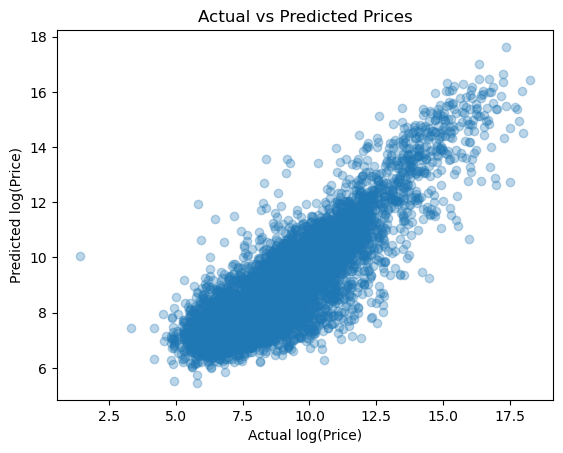

In [217]:
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual log(Price)")
plt.ylabel("Predicted log(Price)")
plt.title("Actual vs Predicted Prices")
plt.show()

## Hyperparameter Tuning for the best model

In [234]:
param_grid = {
    'n_estimators': [200, 400, 600],
    'max_depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0]
}

xgb = XGBRegressor(random_state=42)
search = RandomizedSearchCV(xgb, param_grid, scoring='neg_root_mean_squared_error',
                            cv=3, n_iter=10, verbose=1, n_jobs=-1)
search.fit(X_train, y_train)
print(search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'subsample': 0.9, 'n_estimators': 600, 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


In [240]:
best_xgb = search.best_estimator_

y_pred_val = best_xgb.predict(X_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
r2_val = r2_score(y_val, y_pred_val)

print(f"Validation → RMSE: {rmse_val:.3f}, R²: {r2_val:.3f}")

Validation → RMSE: 1.115, R²: 0.710


In [242]:
X_test = test_df.drop(columns=['price', 'log_price'])
y_test = test_df['log_price']

y_pred_test = best_xgb.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

print(f"Test → RMSE: {rmse_test:.3f}, R²: {r2_test:.3f}")

Test → RMSE: 1.094, R²: 0.731


In [244]:
results_comparison = pd.DataFrame([
    {"Phase": "Before Tuning", "RMSE": 1.0916, "R2": 0.7323},
    {"Phase": "After Tuning (Validation)", "RMSE": rmse_val, "R2": r2_val},
    {"Phase": "After Tuning (Test)", "RMSE": rmse_test, "R2": r2_test}
])
print(results_comparison)

                       Phase      RMSE        R2
0              Before Tuning  1.091600  0.732300
1  After Tuning (Validation)  1.115443  0.709816
2        After Tuning (Test)  1.094231  0.730953


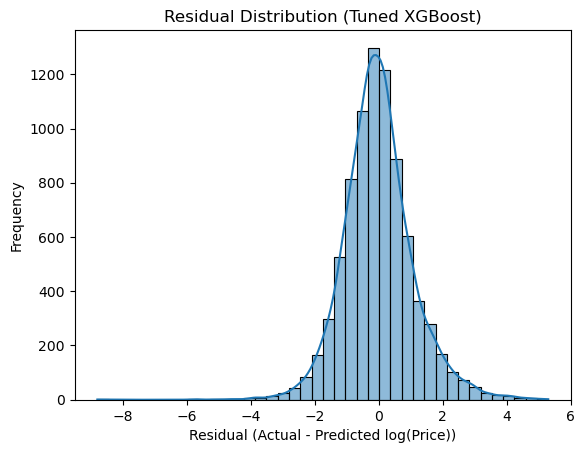

In [238]:
best_xgb = search.best_estimator_

y_pred = best_xgb.predict(X_test)
residuals = y_test - y_pred

sns.histplot(residuals, bins=40, kde=True)
plt.title("Residual Distribution (Tuned XGBoost)")
plt.xlabel("Residual (Actual - Predicted log(Price))")
plt.ylabel("Frequency")
plt.show()

### Linear Regression
- RMSE = 1.59
- R^2 = 0.43
- Underfits and unable to capture non-linear price patterns between artist, year, and material.

### Random Forest
- RMSE = 1.23
- R^2 = 0.66
- Strong baseline and captures complex interactions, interpretable feature importances.

### XGBoost (Baseline)
- RMSE = 1.09
- R^2 = 0.73
- Best performer and learns deeper non-linear relationships, generalizes well.

### XGBoost (Tuned)
- RMSE = 1.09
- R^2 = 0.73
- Comparable generalization, tuning did not improve R² and confirming baseline hyperparameters were already near-optimal.

### Interpretation

- XGBoost dominates — It captures non-linear feature effects and interactions far better than linear or bagging-based models.
- Random Forest remains a close second, offering interpretability and robustness.
- Linear Regression struggles because price is influenced by non-linear, hierarchical factors (artist, material, year).
- Removing sold_year_missing had no impact, confirming it was not informative.
- Dropping sold_year reduced R², verifying that time-related trends are crucial for valuation.

## Feature Importance Insights

### Random Forest
- Price is driven by auction year, artist reputation (artist_score), material, and art size (area).
- Indicates a balanced influence of artistic and contextual factors (both intrinsic and extrinsic).

### XGBoost
- sold_year dominates, capturing strong temporal trends.
- artist_score and material follow closely, reinforcing market perception’s importance.
- Model handled missingness gracefully — dropping missingness flags had no major penalty.

### Residual & Prediction Diagnostics

- Residuals are symmetrically distributed around 0 → no major bias (model neither consistently over- nor under-predicts).
- Actual vs Predicted Plot shows a strong positive correlation along the diagonal → model generalizes well even for high-value sales.